In [97]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error
from tqdm import tqdm
import math


In [98]:
with open('/home/f20222001/test-venv/UHI/Datasets_processed/inputs_36_extra_clean_40k.pkl', 'rb') as f, open('/home/f20222001/test-venv/UHI/Datasets_processed/targets_36_extra_clean_40k.pkl','rb') as t:
    inputs = pickle.load(f)
    targets = pickle.load(t)
# Shuffle before splitting (preserves alignment of X and y)
X_shuffled, y_shuffled = shuffle(inputs, targets, random_state=42)


In [99]:
# y_shuffled.shape
# new_y=y_shuffled[:,5]
# new_y=new_y.reshape(-1,)
# new_y
# y_shuffled=new_y

In [100]:

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_shuffled, y_shuffled, test_size=0.2, random_state=42
)
# X_train, X_test, Y_train, Y_test = train_test_split(
#     X_train, Y_train, test_size=0.2, random_state=42
# )
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.25, random_state=42
)

In [101]:
# Indexes of features to normalize
norm_idx = [0, 1, 2, 3] 

# Flatten for scaling
X_train_flat = X_train.reshape(-1, X_train.shape[2])
X_val_flat   = X_val.reshape(-1, X_val.shape[2])
X_test_flat  = X_test.reshape(-1, X_test.shape[2])

# Initialize arrays to hold the scaled data
X_train_scaled = X_train_flat.copy()
X_val_scaled   = X_val_flat.copy()
X_test_scaled  = X_test_flat.copy()

scaler = StandardScaler()

# Fit on train, transform all
X_train_scaled[:, norm_idx] = scaler.fit_transform(X_train_flat[:, norm_idx])
X_val_scaled[:, norm_idx]   = scaler.transform(X_val_flat[:, norm_idx])
X_test_scaled[:, norm_idx]  = scaler.transform(X_test_flat[:, norm_idx])

# Reshape back to 3D
X_train = X_train_scaled.reshape(X_train.shape)
X_val   = X_val_scaled.reshape(X_val.shape)
X_test  = X_test_scaled.reshape(X_test.shape)

# Flatten y
y_train_flat = Y_train.reshape(-1, 1)
y_val_flat   = Y_val.reshape(-1, 1)
y_test_flat  = Y_test.reshape(-1, 1)

# Standardize y
standard_scaler_y = StandardScaler()
y_train_scaled = standard_scaler_y.fit_transform(y_train_flat)
y_val_scaled   = standard_scaler_y.transform(y_val_flat)
y_test_scaled  = standard_scaler_y.transform(y_test_flat)

# Reshape back to original shape
Y_train = y_train_scaled.reshape(Y_train.shape)
Y_val   = y_val_scaled.reshape(Y_val.shape)
Y_test  = y_test_scaled.reshape(Y_test.shape)


In [102]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)]


In [103]:
X_train.shape

(1501681, 36, 17)

In [104]:
Y_train.shape

(1501681,)

In [105]:
torch.cuda.set_device(2)  

In [106]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(Y_train, dtype=torch.float32))

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(Y_val, dtype=torch.float32))

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(Y_test, dtype=torch.float32))

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [107]:
device = torch.device("cuda")
device

device(type='cuda')

In [108]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model=256, nhead=8, num_layers=3, dim_feedforward=256, dropout=0.1):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_fc = nn.Linear(d_model, 1)  # regression output

    def forward(self, src):
        # src: (batch_size, seq_len, input_dim)
        src = src.permute(1, 0, 2)  # (seq_len, batch_size, input_dim)
        src = self.input_fc(src)   # (seq_len, batch_size, d_model)
        src = self.pos_encoder(src)
        transformer_out = self.transformer_encoder(src)  # (seq_len, batch_size, d_model)
        out = transformer_out[-1]  # take last time step
        return self.output_fc(out).squeeze(-1)


/home/f20222001/test-venv/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100 - Train Loss: 0.2686420977115631


  1%|          | 1/100 [01:05<1:47:53, 65.39s/it]

Epoch 2/100 - Train Loss: 0.2636864185333252


  2%|▏         | 2/100 [02:10<1:46:58, 65.49s/it]

Epoch 3/100 - Train Loss: 0.14286279678344727


  3%|▎         | 3/100 [03:16<1:45:53, 65.50s/it]

Epoch 4/100 - Train Loss: 0.19233722984790802


  4%|▍         | 4/100 [04:21<1:44:42, 65.45s/it]

Epoch 5/100 - Train Loss: 0.10690244287252426


  5%|▌         | 5/100 [05:27<1:43:41, 65.49s/it]

Epoch 6/100 - Train Loss: 0.12186809629201889


  6%|▌         | 6/100 [06:32<1:42:37, 65.50s/it]

Epoch 7/100 - Train Loss: 0.07123741507530212


  7%|▋         | 7/100 [07:38<1:41:32, 65.51s/it]

Epoch 8/100 - Train Loss: 0.11800850182771683


  8%|▊         | 8/100 [08:43<1:40:21, 65.45s/it]

Epoch 9/100 - Train Loss: 0.11702749133110046


  9%|▉         | 9/100 [09:49<1:39:19, 65.49s/it]

Epoch 10/100 - Train Loss: 0.10741143673658371


 10%|█         | 10/100 [10:54<1:38:15, 65.50s/it]

Epoch 11/100 - Train Loss: 0.08891976624727249


 11%|█         | 11/100 [12:00<1:37:10, 65.51s/it]

Epoch 12/100 - Train Loss: 0.08806601911783218


 12%|█▏        | 12/100 [13:05<1:36:01, 65.47s/it]

Epoch 13/100 - Train Loss: 0.08192966878414154


 13%|█▎        | 13/100 [14:11<1:34:53, 65.44s/it]

Epoch 14/100 - Train Loss: 0.07413272559642792


 14%|█▍        | 14/100 [15:16<1:33:50, 65.47s/it]

Epoch 15/100 - Train Loss: 0.05527317896485329


 15%|█▌        | 15/100 [16:22<1:32:47, 65.50s/it]

Epoch 16/100 - Train Loss: 0.06732052564620972


 16%|█▌        | 16/100 [17:27<1:31:45, 65.54s/it]

Epoch 17/100 - Train Loss: 0.09619013965129852


 17%|█▋        | 17/100 [18:33<1:30:36, 65.50s/it]

Epoch 18/100 - Train Loss: 0.10090604424476624


 18%|█▊        | 18/100 [19:38<1:29:33, 65.53s/it]

Epoch 19/100 - Train Loss: 0.07396255433559418


 19%|█▉        | 19/100 [20:44<1:28:30, 65.56s/it]

Epoch 20/100 - Train Loss: 0.10384368896484375


 20%|██        | 20/100 [21:50<1:27:26, 65.58s/it]

Epoch 21/100 - Train Loss: 0.053730614483356476


 21%|██        | 21/100 [22:55<1:26:18, 65.55s/it]

Epoch 22/100 - Train Loss: 0.08969361335039139


 22%|██▏       | 22/100 [24:01<1:25:16, 65.59s/it]

Epoch 23/100 - Train Loss: 0.04984143376350403


 23%|██▎       | 23/100 [25:06<1:24:11, 65.61s/it]

Epoch 24/100 - Train Loss: 0.122898168861866


 24%|██▍       | 24/100 [26:12<1:23:02, 65.56s/it]

Epoch 25/100 - Train Loss: 0.09312714636325836


 25%|██▌       | 25/100 [27:18<1:21:58, 65.57s/it]

Epoch 26/100 - Train Loss: 0.06363489478826523


 26%|██▌       | 26/100 [28:23<1:20:53, 65.59s/it]

Epoch 27/100 - Train Loss: 0.05932634696364403


 27%|██▋       | 27/100 [29:29<1:19:49, 65.60s/it]

Epoch 28/100 - Train Loss: 0.05726095288991928


 28%|██▊       | 28/100 [30:34<1:18:40, 65.56s/it]

Epoch 29/100 - Train Loss: 0.060712333768606186


 29%|██▉       | 29/100 [31:40<1:17:32, 65.53s/it]

Epoch 30/100 - Train Loss: 0.06887795776128769


 30%|███       | 30/100 [32:45<1:16:29, 65.57s/it]

Epoch 31/100 - Train Loss: 0.09094599634408951


 31%|███       | 31/100 [33:51<1:15:26, 65.60s/it]

Epoch 32/100 - Train Loss: 0.07617604732513428


 32%|███▏      | 32/100 [34:57<1:14:23, 65.64s/it]

Epoch 33/100 - Train Loss: 0.060440510511398315


 33%|███▎      | 33/100 [36:02<1:13:14, 65.59s/it]

Epoch 34/100 - Train Loss: 0.06538931280374527


 34%|███▍      | 34/100 [37:08<1:12:09, 65.60s/it]

Epoch 35/100 - Train Loss: 0.07361128181219101


 35%|███▌      | 35/100 [38:14<1:11:04, 65.61s/it]

Epoch 36/100 - Train Loss: 0.07735180109739304


 36%|███▌      | 36/100 [39:19<1:09:59, 65.62s/it]

Epoch 37/100 - Train Loss: 0.07831313461065292


 37%|███▋      | 37/100 [40:25<1:08:52, 65.59s/it]

Epoch 38/100 - Train Loss: 0.05534489080309868


 38%|███▊      | 38/100 [41:30<1:07:47, 65.61s/it]

Epoch 39/100 - Train Loss: 0.059692077338695526


 39%|███▉      | 39/100 [42:36<1:06:40, 65.58s/it]

Epoch 40/100 - Train Loss: 0.09490931779146194


 40%|████      | 40/100 [43:41<1:05:36, 65.60s/it]

Epoch 41/100 - Train Loss: 0.047249577939510345


 41%|████      | 41/100 [44:47<1:04:32, 65.63s/it]

Epoch 42/100 - Train Loss: 0.08221367746591568


 42%|████▏     | 42/100 [45:53<1:03:23, 65.58s/it]

Epoch 43/100 - Train Loss: 0.09001656621694565


 43%|████▎     | 43/100 [46:58<1:02:20, 65.62s/it]

Epoch 44/100 - Train Loss: 0.09100291132926941


 44%|████▍     | 44/100 [48:04<1:01:12, 65.59s/it]

Epoch 45/100 - Train Loss: 0.0478564128279686


 45%|████▌     | 45/100 [49:10<1:00:09, 65.62s/it]

Epoch 46/100 - Train Loss: 0.057938870042562485


 46%|████▌     | 46/100 [50:15<59:05, 65.65s/it]  

Epoch 47/100 - Train Loss: 0.05659116059541702


 47%|████▋     | 47/100 [51:21<58:00, 65.66s/it]

Epoch 48/100 - Train Loss: 0.07441253960132599


 48%|████▊     | 48/100 [52:26<56:51, 65.60s/it]

Epoch 49/100 - Train Loss: 0.04620247706770897


 49%|████▉     | 49/100 [53:32<55:46, 65.62s/it]

Epoch 50/100 - Train Loss: 0.058730389922857285


 50%|█████     | 50/100 [54:38<54:38, 65.57s/it]

Epoch 51/100 - Train Loss: 0.09156777709722519


 51%|█████     | 51/100 [55:43<53:34, 65.60s/it]

Epoch 52/100 - Train Loss: 0.0633247122168541


 52%|█████▏    | 52/100 [56:49<52:27, 65.57s/it]

Epoch 53/100 - Train Loss: 0.07637517899274826


 53%|█████▎    | 53/100 [57:54<51:20, 65.54s/it]

Epoch 54/100 - Train Loss: 0.05100435018539429


 54%|█████▍    | 54/100 [59:00<50:16, 65.58s/it]

Epoch 55/100 - Train Loss: 0.042472224682569504


 55%|█████▌    | 55/100 [1:00:05<49:11, 65.59s/it]

Epoch 56/100 - Train Loss: 0.05799887329339981


 56%|█████▌    | 56/100 [1:01:11<48:07, 65.62s/it]

Epoch 57/100 - Train Loss: 0.07056272029876709


 57%|█████▋    | 57/100 [1:02:17<47:00, 65.59s/it]

Epoch 58/100 - Train Loss: 0.06495920568704605


 58%|█████▊    | 58/100 [1:03:22<45:56, 65.62s/it]

Epoch 59/100 - Train Loss: 0.07415816932916641


 59%|█████▉    | 59/100 [1:04:28<44:51, 65.65s/it]

Epoch 60/100 - Train Loss: 0.04682745039463043


 60%|██████    | 60/100 [1:05:34<43:46, 65.65s/it]

Epoch 61/100 - Train Loss: 0.061062149703502655


 61%|██████    | 61/100 [1:06:39<42:38, 65.61s/it]

Epoch 62/100 - Train Loss: 0.04671976715326309


 62%|██████▏   | 62/100 [1:07:45<41:33, 65.63s/it]

Epoch 63/100 - Train Loss: 0.06711611151695251


 63%|██████▎   | 63/100 [1:08:51<40:28, 65.63s/it]

Epoch 64/100 - Train Loss: 0.06428801268339157


 64%|██████▍   | 64/100 [1:09:56<39:23, 65.64s/it]

Epoch 65/100 - Train Loss: 0.06832428276538849


 65%|██████▌   | 65/100 [1:11:02<38:15, 65.60s/it]

Epoch 66/100 - Train Loss: 0.04229431599378586


 66%|██████▌   | 66/100 [1:12:07<37:11, 65.63s/it]

Epoch 67/100 - Train Loss: 0.059028226882219315


 67%|██████▋   | 67/100 [1:13:13<36:06, 65.65s/it]

Epoch 68/100 - Train Loss: 0.06498042494058609


 68%|██████▊   | 68/100 [1:14:19<34:59, 65.61s/it]

Epoch 69/100 - Train Loss: 0.050011806190013885


 69%|██████▉   | 69/100 [1:15:24<33:54, 65.63s/it]

Epoch 70/100 - Train Loss: 0.03789028152823448


 70%|███████   | 70/100 [1:16:30<32:49, 65.64s/it]

Epoch 71/100 - Train Loss: 0.05579154193401337


 71%|███████   | 71/100 [1:17:36<31:43, 65.65s/it]

Epoch 72/100 - Train Loss: 0.1279296576976776


 72%|███████▏  | 72/100 [1:18:41<30:36, 65.60s/it]

Epoch 73/100 - Train Loss: 0.07041602581739426


 73%|███████▎  | 73/100 [1:19:47<29:30, 65.57s/it]

Epoch 74/100 - Train Loss: 0.0501486137509346


 74%|███████▍  | 74/100 [1:20:52<28:25, 65.59s/it]

Epoch 75/100 - Train Loss: 0.07968586683273315


 75%|███████▌  | 75/100 [1:21:58<27:18, 65.56s/it]

Epoch 76/100 - Train Loss: 0.05936763435602188


 76%|███████▌  | 76/100 [1:23:04<26:14, 65.61s/it]

Epoch 77/100 - Train Loss: 0.05573880299925804


 77%|███████▋  | 77/100 [1:24:09<25:08, 65.58s/it]

Epoch 78/100 - Train Loss: 0.057609234005212784


 78%|███████▊  | 78/100 [1:25:14<24:01, 65.54s/it]

Epoch 79/100 - Train Loss: 0.0959009900689125


 79%|███████▉  | 79/100 [1:26:20<22:57, 65.58s/it]

Epoch 80/100 - Train Loss: 0.0603882372379303


 80%|████████  | 80/100 [1:27:26<21:52, 65.61s/it]

Epoch 81/100 - Train Loss: 0.07502431422472


 81%|████████  | 81/100 [1:28:32<20:47, 65.63s/it]

Epoch 82/100 - Train Loss: 0.050706882029771805


 82%|████████▏ | 82/100 [1:29:37<19:40, 65.61s/it]

Epoch 83/100 - Train Loss: 0.05378624051809311


 83%|████████▎ | 83/100 [1:30:43<18:35, 65.62s/it]

Epoch 84/100 - Train Loss: 0.06312375515699387


 84%|████████▍ | 84/100 [1:31:48<17:29, 65.59s/it]

Epoch 85/100 - Train Loss: 0.10438905656337738


 85%|████████▌ | 85/100 [1:32:54<16:24, 65.62s/it]

Epoch 86/100 - Train Loss: 0.05179718881845474


 86%|████████▌ | 86/100 [1:33:59<15:18, 65.59s/it]

Epoch 87/100 - Train Loss: 0.06020249053835869


 87%|████████▋ | 87/100 [1:35:05<14:12, 65.61s/it]

Epoch 88/100 - Train Loss: 0.0439809188246727


 88%|████████▊ | 88/100 [1:36:11<13:07, 65.63s/it]

Epoch 89/100 - Train Loss: 0.056535735726356506


 89%|████████▉ | 89/100 [1:37:16<12:01, 65.60s/it]

Epoch 90/100 - Train Loss: 0.07476150989532471


 90%|█████████ | 90/100 [1:38:22<10:56, 65.62s/it]

Epoch 91/100 - Train Loss: 0.06794671714305878


 91%|█████████ | 91/100 [1:39:28<09:50, 65.64s/it]

Epoch 92/100 - Train Loss: 0.0585387721657753


 92%|█████████▏| 92/100 [1:40:33<08:45, 65.66s/it]

Epoch 93/100 - Train Loss: 0.048393093049526215


 93%|█████████▎| 93/100 [1:41:39<07:39, 65.61s/it]

Epoch 94/100 - Train Loss: 0.07899162918329239


 94%|█████████▍| 94/100 [1:42:45<06:33, 65.64s/it]

Epoch 95/100 - Train Loss: 0.09464326500892639


 95%|█████████▌| 95/100 [1:43:50<05:28, 65.65s/it]

Epoch 96/100 - Train Loss: 0.04656314477324486


 96%|█████████▌| 96/100 [1:44:56<04:22, 65.59s/it]

Epoch 97/100 - Train Loss: 0.054779719561338425


 97%|█████████▋| 97/100 [1:46:01<03:16, 65.56s/it]

Epoch 98/100 - Train Loss: 0.07260564714670181


 98%|█████████▊| 98/100 [1:47:07<02:11, 65.60s/it]

Epoch 99/100 - Train Loss: 0.051641326397657394


 99%|█████████▉| 99/100 [1:48:13<01:05, 65.63s/it]

Epoch 100/100 - Train Loss: 0.04359516501426697


100%|██████████| 100/100 [1:49:18<00:00, 65.59s/it]


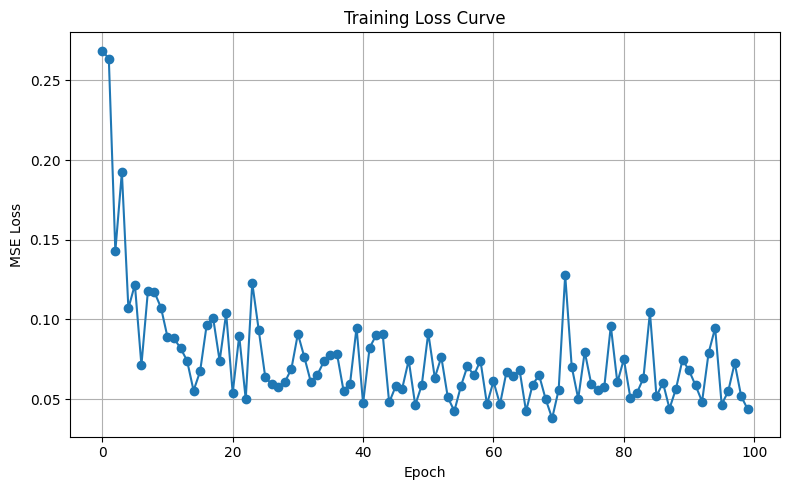

In [109]:
input_size = X_train.shape[2]  # num_features per timestep
model = TransformerRegressor(input_dim=input_size)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0006331, weight_decay=4.701444243150461e-05)

# Training loop
num_epochs = 100
train_losses = []
val_losses = {
    "mse": [],
    "rmse": [],
    "mae": [],
    "r2": []
}

for epoch in tqdm(range(num_epochs)):
    model.train()

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        #print(batch_x.shape)
        #print(batch_y.shape)
        # Forward
        preds = model(batch_x)  # shape: (batch_size,)
        #print(preds.shape)
        loss = criterion(preds, batch_y)
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {loss.item()}")
    train_losses.append(loss.item())

    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x = val_x.to(device)
            val_y = val_y.to(device)

            preds = model(val_x)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(val_y.cpu().numpy())

    # Concatenate and inverse scale
    all_preds_np = np.concatenate(all_preds).reshape(-1, 1)
    all_targets_np = np.concatenate(all_targets).reshape(-1, 1)

    y_pred = standard_scaler_y.inverse_transform(all_preds_np)
    y_true = standard_scaler_y.inverse_transform(all_targets_np)

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    val_losses["mse"].append(mse)
    val_losses["rmse"].append(rmse)
    val_losses["mae"].append(mae)
    val_losses["r2"].append(r2)


plt.figure(figsize=(8, 5))
plt.plot(np.arange(num_epochs),train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [110]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        preds = model(batch_x)
        
        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true).reshape(-1, 1)
y_pred = np.array(y_pred).reshape(-1, 1)

# Unnormalize using RobustScaler
y_true = standard_scaler_y.inverse_transform(y_true)
y_pred = standard_scaler_y.inverse_transform(y_pred)

# Flatten back
y_true = y_true.flatten()
y_pred = y_pred.flatten()

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape=mean_absolute_percentage_error(y_true, y_pred)
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test R²:   {r2:.4f}")
print(f"Test MAPE:   {mape:.4f}")

Test MSE:  5.2475
Test RMSE: 2.2907
Test MAE:  1.4666
Test R²:   0.9327
Test MAPE:   0.0647


In [111]:
val_losses['mae']

[3.124926805496216,
 2.942218065261841,
 2.511018991470337,
 2.233081340789795,
 2.0717992782592773,
 1.9891681671142578,
 1.802619457244873,
 1.9209661483764648,
 1.717281699180603,
 1.7709624767303467,
 1.7795825004577637,
 1.6319977045059204,
 1.704671859741211,
 1.6474000215530396,
 1.5703024864196777,
 1.6231096982955933,
 1.6214361190795898,
 1.561461091041565,
 1.5776842832565308,
 1.7020845413208008,
 1.5471982955932617,
 1.5235754251480103,
 1.5748170614242554,
 1.6003602743148804,
 1.519850254058838,
 1.5833656787872314,
 1.4601755142211914,
 1.5700362920761108,
 1.5482310056686401,
 1.5431840419769287,
 1.521855115890503,
 1.4948492050170898,
 1.5967040061950684,
 1.4809672832489014,
 1.5146729946136475,
 1.512774109840393,
 1.6262247562408447,
 1.5782748460769653,
 1.476648211479187,
 1.5321699380874634,
 1.5572232007980347,
 1.5058412551879883,
 1.513588547706604,
 1.5185973644256592,
 1.5845340490341187,
 1.5188850164413452,
 1.5003676414489746,
 1.490444302558899,
 1.732